In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/tornikeo/Documents/uni/PRCV/proj


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
from pathlib import Path
import random
import re

In [4]:
from utils import load_mnist, load_training_data

d_x, d_y = load_training_data()

In [6]:
d_x[0]

,0,1,2
0,-8.92830,304.45,-18.469
1,-9.14750,304.36,-18.585
2,-9.86880,304.32,-18.896
3,-11.69000,303.81,-19.305
4,-14.82100,302.69,-19.284
5,-19.58500,300.62,-19.579
6,-25.51100,295.96,-19.006
7,-31.59000,287.91,-18.021
8,-36.29700,275.38,-19.003
9,-37.79700,264.15,-18.385


In [4]:
from skimage.transform import rescale,resize
from skimage.morphology import erosion, skeletonize
from skimage.filters import unsharp_mask
from skimage.filters import gaussian
from skimage.restoration import richardson_lucy, deconvolution
from tqdm import tqdm

mx_x = []
for x in tqdm(m_x):
    # x = erosion(x)
    # x = rescale(x,2)
    x = resize(x,(64,64))
    mx_x.append(x)
mx_x = np.stack(mx_x)
    # psf = np.ones((7,7))/49
    # x = richardson_lucy(x, psf, num_iter=10)
    # x = unsharp_mask(x, radius=1, amount=1)
    # x = deconvolution.
    # x = skeletonize(x)
    # x = gaussian(x)
    # show(x)

100%|██████████| 70000/70000 [00:14<00:00, 4725.49it/s]


In [5]:
mx_x = mx_x.astype('float32')

In [6]:
from utils import load_rasterized_data, show

data_x, data_y = load_rasterized_data(size=64, pad=4)

(1000, 64, 64)

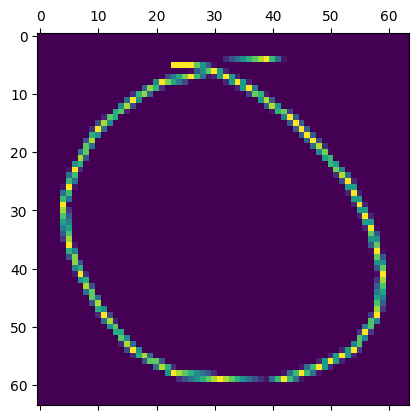

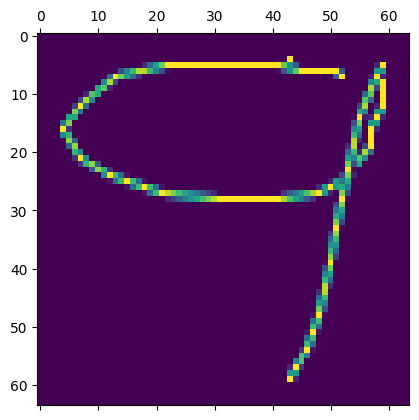

In [7]:
show(data_x[0])
show(data_x[-1])
data_x.shape

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import torch

# Split the LM data into 50/50
# Add MNIST to training half, test with only LM held-out dataset.
x_train, x_test, y_train, y_test = train_test_split(
    data_x, 
    data_y, 
    test_size=0.50, 
    shuffle=True,
    stratify=data_y,
    random_state=42,
)

x_train = x_train / 255
x_test = x_test / 255

x_train = np.concatenate((mx_x, x_train)) 
y_train = np.concatenate((m_y, y_train))

# x_train = x_train.reshape(len(x_train), -1)
# x_test = x_test.reshape(len(x_test), -1)

x_train = torch.tensor(x_train).float().unsqueeze(1)
x_train_lm = x_train[-500:]
x_test = torch.tensor(x_test).float().unsqueeze(1)

y_train = torch.tensor(y_train)
y_train_lm = y_train[-500:]
y_test = torch.tensor(y_test)

In [9]:
from torch import nn
from torch.utils import data
from torch.nn import functional as F

train_ds = data.TensorDataset(x_train, y_train)
test_ds = data.TensorDataset(x_test, y_test)

train_dl = data.DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = data.DataLoader(test_ds, batch_size=32, shuffle=True)

# train_main_dl

class Net(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.cnn_block = nn.Sequential(
            nn.Conv2d(1, 8, (3, 3),),
            nn.MaxPool2d((2,2)),
            nn.ReLU(),
            
            nn.Conv2d(8, 32, (3, 3)),
            nn.MaxPool2d((2,2)),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, (3, 3)),
            nn.MaxPool2d((2,2)),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, (3, 3)),
            nn.AvgPool2d(4),
            nn.ReLU(),
        )
        # self.bn = nn.BatchNorm2d(32)
        self.flat = nn.Flatten()
        self.ff = nn.Linear(128, 100)
        self.out = nn.Linear(100, 10)
    def forward(self, x):
        x = self.cnn_block(x)
        
        x = self.flat(x)
        # print(x.shape)
        x = F.leaky_relu(self.ff(x))
        x = self.out(x)
        return x
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net()
optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9)
model.to(device)

for ep in range(10):
    for bn, (xb, yb) in enumerate(train_dl):
        xb = xb.to(device)
        yb = yb.to(device)
        ll = model(xb)
        loss = F.nll_loss(F.log_softmax(ll, dim=1), yb)
        loss.backward()
        optim.step()
        optim.zero_grad()
    print("MNIST LOSS", loss.item(), end='\r')
print()

for _ in range(10): 
    optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9)
    x_train_lm = x_train_lm.to(device)
    y_train_lm = y_train_lm.to(device)
    for _ in range(100):
        ll = model(x_train_lm)
        loss = F.nll_loss(F.log_softmax(ll, dim=1), y_train_lm)
        loss.backward()
        optim.step()
        optim.zero_grad()
        # We are only interested in loss over LM data
        print("LeapMotion LOSS", loss.item(), end='\r')
    print()

    with torch.no_grad():
        
        model.eval()
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        
        ll = model(x_test)
        proba = F.log_softmax(ll, dim=1)
        loss = F.nll_loss(proba, y_test)
        predicted = proba.argmax(-1)
        
        print(classification_report(y_test.cpu(), predicted.cpu()))
        print(confusion_matrix(y_test.cpu(), predicted.cpu()))

MNIST LOSS 0.14700093865394592538
LeapMotion LOSS 0.016503222286701202
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        50
           1       0.94      0.90      0.92        50
           2       0.94      1.00      0.97        50
           3       1.00      1.00      1.00        50
           4       0.96      0.94      0.95        50
           5       0.98      0.98      0.98        50
           6       0.96      0.96      0.96        50
           7       0.94      0.96      0.95        50
           8       0.96      0.96      0.96        50
           9       0.96      0.94      0.95        50

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500

[[48  0  0  0  0  1  1  0  0  0]
 [ 0 45  1  0  0  0  0  3  1  0]
 [ 0  0 50  0  0  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0]
 [ 1  0  0  0 47  0  0  0  0  2]
 [ 0 